<a href="https://colab.research.google.com/github/fahim-03/NLP_Labs/blob/main/lab_2_bag_of_words_and_distributional_semantics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
__author__ = "Pranava Madhyastha"
__version__ = "INM434/IN3045 City, University of London, Spring 2026"

---
#Completing BPE: Handling OOV Words <a name="bpe-oov"></a>

In the last lab, we implemented the BPE training algorithm. Now let's complete it by implementing the **tokenizer** that can handle any input, including out-of-vocabulary words.

In [9]:
# BPE Training functions from last week

def get_pair_frequencies(vocab):

    pairs = {}
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pair = (symbols[i], symbols[i + 1])
            pairs[pair] = pairs.get(pair, 0) + freq
    return pairs

def merge_vocab(pair, vocab):

    new_vocab = {}
    bigram = ' '.join(pair)
    replacement = ''.join(pair)
    for word, freq in vocab.items():
        new_word = word.replace(bigram, replacement)
        new_vocab[new_word] = freq
    return new_vocab

def learn_bpe(corpus_vocab, num_merges):

    vocab = {' '.join(word) + ' </w>': freq for word, freq in corpus_vocab.items()}
    merges = []
    for i in range(num_merges):
        pairs = get_pair_frequencies(vocab)
        if not pairs:
            break
        best_pair = max(pairs, key=pairs.get)
        vocab = merge_vocab(best_pair, vocab)
        merges.append(best_pair)
        print(f"Merge {i+1}: {best_pair} -> {''.join(best_pair)}")
    return vocab, merges

# Let us now train on a small corpus
corpus_vocab = {'low': 5, 'lower': 2, 'newest': 6, 'widest': 3, 'slow': 4, 'slower': 3}

final_vocab, bpe_merges = learn_bpe(corpus_vocab, 10)
print(bpe_merges)
print(final_vocab)

Merge 1: ('l', 'o') -> lo
Merge 2: ('lo', 'w') -> low
Merge 3: ('low', '</w>') -> low</w>
Merge 4: ('e', 's') -> es
Merge 5: ('es', 't') -> est
Merge 6: ('est', '</w>') -> est</w>
Merge 7: ('n', 'e') -> ne
Merge 8: ('ne', 'w') -> new
Merge 9: ('new', 'est</w>') -> newest</w>
Merge 10: ('low', 'e') -> lowe
[('l', 'o'), ('lo', 'w'), ('low', '</w>'), ('e', 's'), ('es', 't'), ('est', '</w>'), ('n', 'e'), ('ne', 'w'), ('new', 'est</w>'), ('low', 'e')]
{'low</w>': 5, 'lowe r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3, 's low</w>': 4, 's lowe r </w>': 3}


In [5]:
def bpe_tokenize(word, merges):

    # Start with characters + end-of-word marker
    word = list(word) + ['</w>']

    # Apply merges in the order they were learned
    for merge_pair in merges:
        i = 0
        while i < len(word) - 1:
            if (word[i], word[i + 1]) == merge_pair:
                # Merge the pair into a single token
                word = word[:i] + [''.join(merge_pair)] + word[i + 2:]
            else:
                i += 1

    return word

# Test on known words

for word in ['low', 'lower', 'newest', 'loved']:
    tokens = bpe_tokenize(word, bpe_merges)
    print(f"  {word:15} -> {tokens}")

for word in ['lowest', 'lover', 'newly', 'unwanted', 'xyz']:
    tokens = bpe_tokenize(word, bpe_merges)
    print(f"  {word:15} -> {tokens}")

  low             -> ['low</w>']
  lower           -> ['lower</w>']
  newest          -> ['newest</w>']
  loved           -> ['lo', 'v', 'e', 'd', '</w>']
  lowest          -> ['low', 'est</w>']
  lover           -> ['lo', 'v', 'e', 'r', '</w>']
  newly           -> ['new', 'l', 'y', '</w>']
  unwanted        -> ['u', 'n', 'w', 'a', 'n', 't', 'e', 'd', '</w>']
  xyz             -> ['x', 'y', 'z', '</w>']


### Todo: Tokenize these words - ['lowest', 'lover', 'newly', 'unwanted', 'xyz']

# Notice and remember a few things:

- "lowest" is decomposed into known subwords like "low" + "est"
- "xyz" falls back to individual characters

No word is truly unknown! We can always decompose it into smaller pieces.

This is why BPE is used in virtually all modern NLP.

# Back to Classiciation and a focus on Bag of Words based features

Let's go back to classification, we have explored classification in the previous lab with Naive Bayes, here let's try logistic regression instead.

We shall begin with a similar classification dataset as before.

In [11]:
# Sample sentiment dataset
positive_reviews = [
    "I love this movie it is amazing",
    "Great film with excellent acting",
    "This is the best movie I have seen",
    "Wonderful story and beautiful cinematography",
    "Highly recommend this fantastic film",
    "The performances were outstanding and moving",
    "A masterpiece of modern cinema",
    "Brilliant direction and superb screenplay",
    "I enjoyed every minute of this film",
    "An absolute delight to watch",
    "Incredible acting and gripping storyline",
    "One of the best films of the year",
]

negative_reviews = [
    "This movie is terrible and boring",
    "Worst film I have ever seen",
    "Complete waste of time and money",
    "The acting was awful and the plot made no sense",
    "I hated every moment of this disaster",
    "Disappointing and poorly made",
    "A terrible excuse for entertainment",
    "Bad acting and worse writing",
    "I regret watching this garbage",
    "Absolutely dreadful from start to finish",
    "Boring plot and forgettable characters",
    "A complete waste of talent",
]

texts = positive_reviews + negative_reviews
labels = [1] * len(positive_reviews) + [0] * len(negative_reviews)

In [12]:
import random

# Combine and shuffle (why would we do this?)
data = list(zip(texts, labels))
# print(data)
random.seed(42)
random.shuffle(data)

# Split 80/20
split_idx = int(0.8 * len(data))
train_data = data[:split_idx]
test_data = data[split_idx:]

train_texts, train_labels = zip(*train_data)
test_texts, test_labels = zip(*test_data)

# TODO: Print out the total number of train and test samples
print(f"Total number of training samples: {len(train_data)}")
print(f"Total number of testing samples: {len(test_data)}")


Total number of training samples: 19
Total number of testing samples: 5


# Let us now revisit bag of words representation (or bag of words features)

In [24]:
import re
from collections import Counter
import numpy as np

# we will approach this in the same way as scikit-learn approaches functions

def simple_tokenize(text):
    # we will reuse the tokenization style as last time
    return re.findall(r'\b\w+\b', text.lower())

class BagOfWordsVectorizer:

    def __init__(self):
        self.vocabulary = {}
        self.vocab_size = 0

    def fit(self, texts):
        word_set = set()
        for text in texts:
            tokens = simple_tokenize(text)
            word_set.update(tokens)

        # Create word to index mapping
        self.vocabulary = {word: idx for idx, word in enumerate(sorted(word_set))}
        self.vocab_size = len(self.vocabulary)
        #TODO: Print out the vocab size
        print(f"Vocabulary size: {self.vocab_size}")
        return self

    def transform(self, texts):
        vectors = np.zeros((len(texts), self.vocab_size))

        for i, text in enumerate(texts):
            tokens = simple_tokenize(text)
            for token in tokens:
                if token in self.vocabulary:
                    vectors[i, self.vocabulary[token]] += 1

        return vectors

    def fit_transform(self, texts):
        self.fit(texts)
        return self.transform(texts)

# Create vectorizer and transform training data
vectorizer = BagOfWordsVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

y_train = np.array(train_labels)
y_test = np.array(test_labels)

print(X_train[0]) #The first sample is the first row in our training data BOW
print(y_test[0]) #The sentiment/label for our first sample


Vocabulary size: 71
[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
1


### TODO: Please try and visualise a bag of word vector for the first sample

---
# Logistic Regression from Scratch

Now let's implement logistic regression to understand how it works internally.

In [19]:
def sigmoid(z):

    # Clip to avoid overflow
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

class LogisticRegressionScratch:


    def __init__(self, learning_rate=0.1, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        self.losses = []

    def fit(self, X, y):

        n_samples, n_features = X.shape

        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.losses = []

        # Gradient descent
        for i in range(self.num_iterations):
            # Forward pass: compute predictions
            z = np.dot(X, self.weights) + self.bias
            y_pred = sigmoid(z)

            # Compute loss (cross-entropy)
            epsilon = 1e-15  # Avoid log(0)
            loss = -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
            self.losses.append(loss)

            # Backward pass: compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            # Update weights
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Print progress
            if (i + 1) % 100 == 0:
                print(f"Iteration {i+1}/{self.num_iterations}, Loss: {loss:.4f}")

        return self

    def predict_proba(self, X):

        z = np.dot(X, self.weights) + self.bias
        return sigmoid(z)

    def predict(self, X):

        return (self.predict_proba(X) >= 0.5).astype(int)

# Train the model

model = LogisticRegressionScratch(learning_rate=0.5, num_iterations=1000)
model.fit(X_train, y_train)

Iteration 100/1000, Loss: 0.0959
Iteration 200/1000, Loss: 0.0485
Iteration 300/1000, Loss: 0.0322
Iteration 400/1000, Loss: 0.0240
Iteration 500/1000, Loss: 0.0191
Iteration 600/1000, Loss: 0.0159
Iteration 700/1000, Loss: 0.0136
Iteration 800/1000, Loss: 0.0119
Iteration 900/1000, Loss: 0.0105
Iteration 1000/1000, Loss: 0.0095


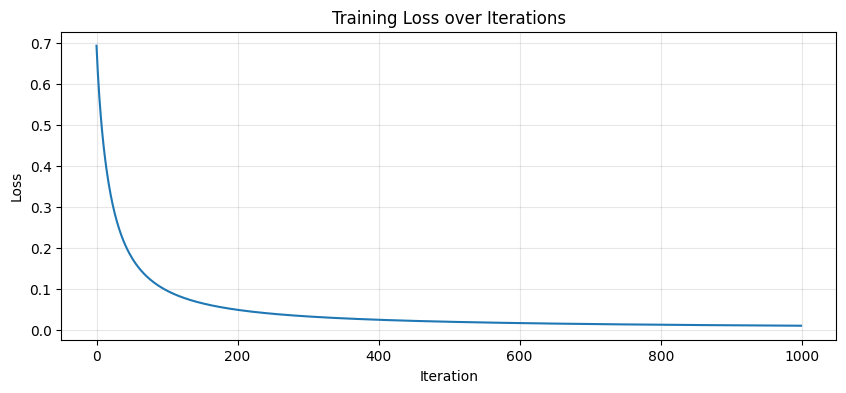

In [18]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(model.losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
# Evaluate
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_acc = np.mean(train_pred == y_train)
test_acc = np.mean(test_pred == y_test)

# TODO: Print the training and test accuracy
print(f"Training accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


Training accuracy: 1.0000
Test accuracy: 0.4000


In [27]:
# Let us now examine learned weights
print("listing top 10 positive words (highest weights):")
top_positive = np.argsort(model.weights)[-10:][::-1]
for idx in top_positive:
    print(f"  {idx_to_word[idx]:15} weight: {model.weights[idx]:+.3f}")

print("listing top 10 negative words (lowest weights):")
top_negative = np.argsort(model.weights)[:10]
for idx in top_negative:
    print(f"  {idx_to_word[idx]:15} weight: {model.weights[idx]:+.3f}")

listing top 10 positive words (highest weights):
  best            weight: +2.076
  storyline       weight: +1.803
  gripping        weight: +1.803
  incredible      weight: +1.803
  the             weight: +1.774
  cinema          weight: +1.604
  masterpiece     weight: +1.604
  modern          weight: +1.604
  performances    weight: +1.235
  moving          weight: +1.235
listing top 10 negative words (lowest weights):
  terrible        weight: -2.043
  and             weight: -1.892
  made            weight: -1.691
  ever            weight: -1.685
  worst           weight: -1.685
  boring          weight: -1.668
  complete        weight: -1.504
  waste           weight: -1.504
  plot            weight: -1.441
  bad             weight: -1.101


The learned weights seem to tell us which words indicate positive vs negative sentiment!
- **Positive weights** are words associated with positive sentiment (or the ones with label 1)
- **Negative weights** are words associated with negative sentiment (or the ones with label 0)

This interpretability is a major advantage of linear models -- it identifies features that are directly modulated and composed to obtain the label.




In practice, we use optimized libraries. Let's see how scikit-learn handles this.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Using sklearn's CountVectorizer
sklearn_vectorizer = CountVectorizer()
X_train_sklearn = sklearn_vectorizer.fit_transform(train_texts)
X_test_sklearn = sklearn_vectorizer.transform(test_texts)

# Train logistic regression
sklearn_model = LogisticRegression(max_iter=1000)
sklearn_model.fit(X_train_sklearn, y_train)

# Evaluate
y_pred = sklearn_model.predict(X_test_sklearn)
bias = sklearn_model.intercept_
print(f"bias: {bias}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

bias: [-0.34258949]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.20      1.00      0.33         1
    Positive       0.00      0.00      0.00         4

    accuracy                           0.20         5
   macro avg       0.10      0.50      0.17         5
weighted avg       0.04      0.20      0.07         5



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
# Compare unigrams vs bigrams
# Here you could potentially try engineering features - try with bigrams, uni+bigrams, etc.

configs = [
    ('Unigrams', CountVectorizer()),
    ('Bigrams', CountVectorizer(ngram_range=(2, 2))),
    ('Uni+Bigrams', CountVectorizer(ngram_range=(1, 2))),
]

for name, vec in configs:
    X_tr = vec.fit_transform(train_texts)
    X_te = vec.transform(test_texts)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_tr, y_train)
    acc = clf.score(X_te, y_test)

    print(f"{name:15} | Vocab size: {len(vec.vocabulary_):5} | Test acc: {acc:.2%}")

Unigrams        | Vocab size:    69 | Test acc: 20.00%
Bigrams         | Vocab size:    82 | Test acc: 20.00%
Uni+Bigrams     | Vocab size:   151 | Test acc: 20.00%


# The Problem with Bag-of-Words

Let's first understand why BoW representations have fundamental limitations.

In [26]:
# Let's go back to our first example:
# let us obtain reverse vocabulary
idx_to_word = {idx: word for word, idx in vectorizer.vocabulary.items()}

# Get BoW vectors for "great" and "wonderful" by transforming single-word texts
great_vector = vectorizer.transform(["great"])[0]
wonderful_vector = vectorizer.transform(["wonderful"])[0]

In [29]:
def cosine_sim(a, b):
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        return 0
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [30]:
# what is the cosine similarity between great and wonderful?
cosine_sim(great_vector, wonderful_vector)

0

# What is the problem?
It seems like the vectors are orthogonal and there is no way we are able to use the information that great and wonderful have some relationship!

# The distributional hypothesis

> *"You shall know a word by the company it keeps."* — J.R. Firth (1957)

Words that appear in similar **contexts** (of words) tend to have similar **meanings**.

In [34]:
# Let's look at the contexts of different words
corpus = """
The dog barked at the cat. The cat ran away.
I love my dog. My dog is friendly.
The cat sleeps all day. I pet my cat.
Dogs and cats are popular pets.
Democracy requires participation from citizens.
The government should serve the people.
Democracy is the foundation of our society.
"""

def get_contexts(corpus, target_word, window=2):
    """Get all context words within a window around the target word."""
    tokens = simple_tokenize(corpus)
    contexts = []

    for i, token in enumerate(tokens):
        if token == target_word:
            # Get words in window
            start = max(0, i - window)
            end = min(len(tokens), i + window + 1)
            context = [tokens[j] for j in range(start, end) if j != i]
            contexts.extend(context)

    return Counter(contexts)

print("Context words for 'dog':")
dog_contexts = get_contexts(corpus, 'dog', window=2)
print(dict(dog_contexts))

print("\nContext words for 'cat':")
cat_contexts = get_contexts(corpus, 'cat', window=2)
print(dict(cat_contexts))

print("\nContext words for 'democracy':")
democracy_contexts = get_contexts(corpus, 'democracy', window=2)
print(dict(democracy_contexts))

Context words for 'dog':
{'the': 1, 'barked': 1, 'at': 1, 'love': 1, 'my': 3, 'dog': 2, 'is': 1, 'friendly': 1}

Context words for 'cat':
{'at': 1, 'the': 4, 'cat': 2, 'ran': 1, 'away': 1, 'friendly': 1, 'sleeps': 1, 'all': 1, 'pet': 1, 'my': 1, 'dogs': 1, 'and': 1}

Context words for 'democracy':
{'popular': 1, 'pets': 1, 'requires': 1, 'participation': 1, 'the': 2, 'people': 1, 'is': 1}


Notice:
- **'dog' and 'cat'** share similar contexts: "the", "my", "pet"
- **'democracy'** has very different contexts: "requires", "is", "foundation"

This is the distributional hypothesis in action!

---
## Building a Co-occurrence Matrix
Let's represent words by their context distributions.

In [36]:
def build_cooccurrence_matrix(corpus, window=2):

    tokens = simple_tokenize(corpus)
    vocab = sorted(set(tokens))
    word_to_idx = {word: i for i, word in enumerate(vocab)}
    n = len(vocab)

    # Initialize matrix
    matrix = np.zeros((n, n))

    # Count co-occurrences
    for i, token in enumerate(tokens):
        target_idx = word_to_idx[token]

        # Look at context window
        start = max(0, i - window)
        end = min(len(tokens), i + window + 1)

        for j in range(start, end):
            if j != i:
                context_idx = word_to_idx[tokens[j]]
                matrix[target_idx, context_idx] += 1

    return matrix, vocab, word_to_idx

# Build matrix
cooc_matrix, vocab, word_to_idx = build_cooccurrence_matrix(corpus, window=2)



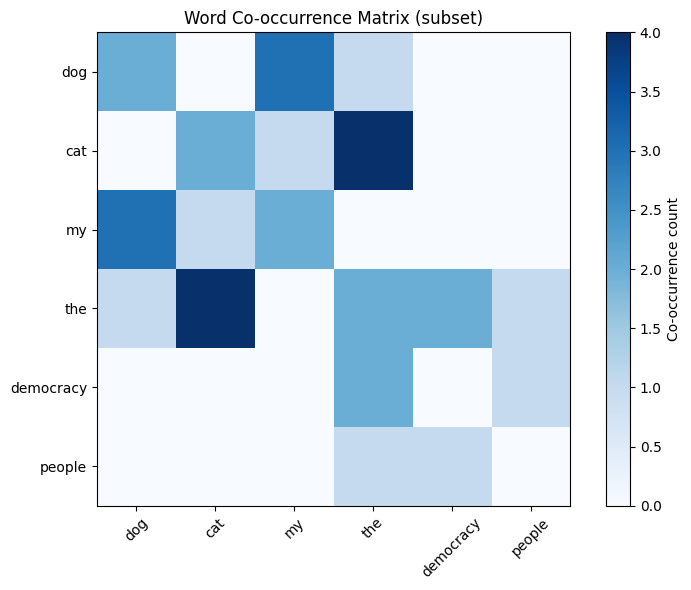

In [37]:
# Let us try and visualize part of the matrix
import matplotlib.pyplot as plt

# Select interesting words
words_of_interest = ['dog', 'cat', 'my', 'the', 'democracy', 'people']
indices = [word_to_idx[w] for w in words_of_interest if w in word_to_idx]
words_found = [vocab[i] for i in indices]

# Extract submatrix
submatrix = cooc_matrix[np.ix_(indices, indices)]

plt.figure(figsize=(8, 6))
plt.imshow(submatrix, cmap='Blues')
plt.colorbar(label='Co-occurrence count')
plt.xticks(range(len(words_found)), words_found, rotation=45)
plt.yticks(range(len(words_found)), words_found)
plt.title('Word Co-occurrence Matrix (subset)')
plt.tight_layout()
plt.show()

In [38]:
# Now compute similarity using co-occurrence vectors
def get_word_vector(word, matrix, word_to_idx):

    if word not in word_to_idx:
        return None
    return matrix[word_to_idx[word]]

# Get vectors
dog_vec = get_word_vector('dog', cooc_matrix, word_to_idx)
cat_vec = get_word_vector('cat', cooc_matrix, word_to_idx)
democracy_vec = get_word_vector('democracy', cooc_matrix, word_to_idx)

print("cosine similarities using co-occurrence vectors:")
print(f"  sim(dog, cat): {cosine_sim(dog_vec, cat_vec):.4f}")
print(f"  sim(dog, democracy): {cosine_sim(dog_vec, democracy_vec):.4f}")
print(f"  sim(cat, democracy): {cosine_sim(cat_vec, democracy_vec):.4f}")


cosine similarities using co-occurrence vectors:
  sim(dog, cat): 0.3770
  sim(dog, democracy): 0.2176
  sim(cat, democracy): 0.4619


Representing words with their **context distributions** we are able to capture semantic similarity!

But there's still a problem: common words like "the" dominate the counts...

#### ADVANCED TODO: Implement PMI

Pointwise Mutual Information (PMI) is a weighting scheme - that helps normalising the issue like the above -- where frequent words dominate almost every single vector.

$$PMI(w, c) = \log \frac{P(w, c)}{P(w) \cdot P(c)}$$

For more details refer to https://web.stanford.edu/~jurafsky/slp3/J.pdf.

Implement PMI for the co-occurrence matrix.


In [42]:
def compute_pmi(cooc_matrix):
    """
    Compute PMI from a co-occurrence matrix.

    Args:
        cooc_matrix: Word-word co-occurrence counts

    Returns:
        PMI matrix (same shape as input)
    """
    # YOUR CODE HERE
    # 1. Compute total count
    total = sum(cooc_matrix)
    # 2. Compute P(w) for each word (row sums / total)
    row_sums = np.sum(cooc_matrix,axis=1) #axis=1 for  row sum axis=0 for column sum
    P_w = row_sums / total
    # 3. Compute P(c) for each context (column sums / total)
    col_sums = np.sum(cooc_matrix,axis=0)
    P_c = col_sums / total
    # 4. Compute P(w,c) from cooc_matrix / total
    P_wc = cooc_matrix / total
    # 5. PMI = log(P(w,c) / (P(w) * P(c)))
    PMI = np.log((P_wc / (np.outer(P_w, P_c))+ 1e-8)) # We add a very small number as log(0) is infinite
    PMI = np.maximum(PMI, 0) # not interested in negative connections
    # Note: Handle zeros appropriately!
    return PMI

# Test your implementation
pmi_matrix = compute_pmi(cooc_matrix)
print("PMI matrix computed!")
print(f"Shape: {pmi_matrix.shape}")

PMI matrix computed!
Shape: (35, 35)


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

def get_review_vector(review, word_to_idx, embeddings):
    # 1. Tokenize (using simple split to match earlier steps)
    tokens = review.lower().split()

    # 2. Collect vectors for words that exist in our vocab
    vectors = []
    for token in tokens:
        if token in word_to_idx:
            idx = word_to_idx[token]
            vectors.append(embeddings[idx])

    # 3. Average them
    if len(vectors) == 0:
        # If no words are found, return a vector of zeros
        return np.zeros(embeddings.shape[1])

    return np.mean(vectors, axis=0)

# --- 1. Transform Data ---
# We use 'train_texts' and 'test_texts' from your split
X_train_pmi = [get_review_vector(r, word_to_idx, pmi_matrix) for r in train_texts]
X_test_pmi = [get_review_vector(r, word_to_idx, pmi_matrix) for r in test_texts]

# --- 2. Train Classifier ---
model = LogisticRegression()
model.fit(X_train_pmi, train_labels)

# --- 3. Evaluate ---
preds = model.predict(X_test_pmi)
acc = accuracy_score(test_labels, preds)

print(f"New Test Accuracy with PMI Embeddings: {acc:.4f}")

New Test Accuracy with PMI Embeddings: 0.2000
